In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
from rdkit.ML.Cluster import Butina
from rdkit.DataManip.Metric import GetTanimotoSimMat

### Reading data

Creating the mol objects from smiles and couple it with CHEMBL IDs, then generating the fingerprints for each mol

In [51]:
compound_df = pd.read_csv('/Users/painguin/Downloads/molecule_07_03.csv', sep=',')
compounds = []
for _, chembl_id, smiles in tqdm(compound_df[["molecule_chembl_id", "canonical_smiles"]].itertuples()):
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator()
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in tqdm(compounds)]

0it [00:00, ?it/s]

  0%|          | 0/12755 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Creating tanimoto similarity matrix

Tanimoto_distance_matrix is the function for calculating the similarities and the tanimoto distances from a tanimoto coefficients (for each fingerprint) to create a dissimilarity matrix. Cluster_fingerprints clusterizes the data into clusters using the Butina clustering algorithm(https://pubs.acs.org/doi/abs/10.1021/ci9803381), then we're grouping fingerprints by clusters. Creating the clusters dictionary and adding new colomns to a dataframe compound_df


In [ ]:
def tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in tqdm(range(1, len(fp_list))):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def cluster_fingerprints(fingerprints, cutoff=0.2):
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

clusters = cluster_fingerprints(fingerprints)
clusterized_fingerprints = [fingerprints[index] for cluster in clusters for index in cluster]

cluster_dict = dict()
for cluster in range(len(clusters)):
    cluster_dict.update({compounds[_][1]:cluster for _ in clusters[cluster]})

compound_df['cluster'] = compound_df['molecule_chembl_id'].apply(lambda x: cluster_dict[x])
compound_df['singleton_cluster'] = compound_df.groupby('cluster')['molecule_chembl_id'].transform("count").apply(lambda x: x == 1)
centroid_list = [compounds[_[0]][1] for _ in clusters]
compound_df['centroid_cluster'] = compound_df['molecule_chembl_id'].apply(lambda x: x in centroid_list)

  0%|          | 0/12754 [00:00<?, ?it/s]

Visualizing similarities by creating the symmetric tanimoto matrix

In [ ]:
similarity_scores = np.round(GetTanimotoSimMat(clusterized_fingerprints), 2).astype('float16')

n_mol = len(clusterized_fingerprints)
similarity_matrix = np.ones((n_mol, n_mol), dtype=np.float16)

k = 0
for i in tqdm(range(n_mol)):
    for j in range(i):
        similarity_matrix[i, j] = similarity_scores[k]
        similarity_matrix[j, i] = similarity_scores[k]  
        k += 1

np.save('similarity_matrix.npy', similarity_matrix)

  0%|          | 0/12755 [00:00<?, ?it/s]

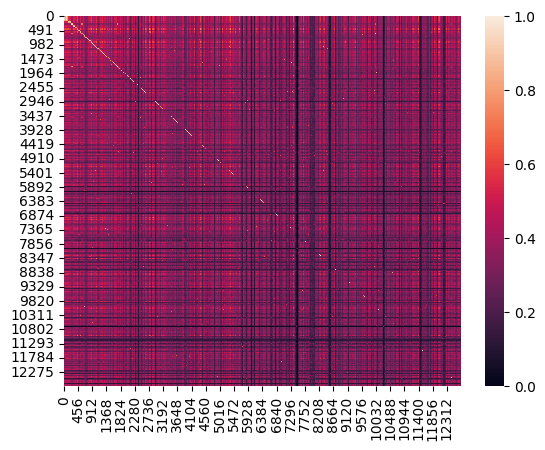

In [ ]:
# matrix without scaling

similarity_matrix = np.load('similarity_matrix.npy')
sns.heatmap(similarity_matrix)
plt.show()

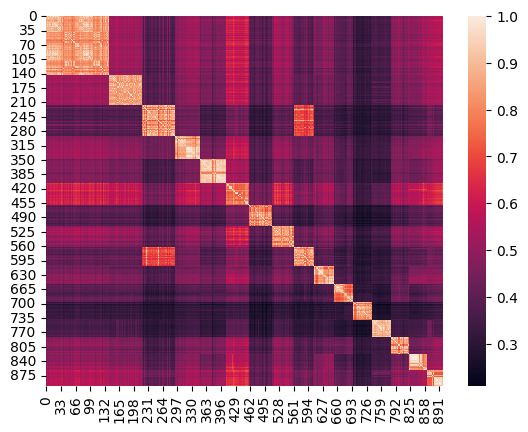

In [52]:
# scaled matrix

sns.heatmap(similarity_matrix[:900, :900])
plt.show()

### Searching for MCS

Statistics from clusters

In [ ]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total clusters: ", len(clusters))
print("clusters with only 1 compound: ", num_clust_g1)
print("clusters with >5 compounds: ", num_clust_g5)
print("clusters with >25 compounds: ", num_clust_g25)
print("clusters with >100 compounds: ", num_clust_g100)

total clusters:  4688
clusters with only 1 compound:  2747
clusters with >5 compounds:  443
clusters with >25 compounds:  40
clusters with >100 compounds:  1


Computing the largest cluster from the molecule set

In [ ]:
sdf = Chem.SDWriter("molecule_set_largest_cluster.sdf")

# writing mols into a file
for index in clusters[0]:
    mol, label = compounds[index]
    # addition of the metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)

sdf.flush()
sdf.close()

# reading mols from a file
supplier = Chem.ForwardSDMolSupplier("molecule_set_largest_cluster.sdf")
mols = [mol for mol in supplier if mol is not None]


Finding the Most Common Structure for the largest cluster using rdFMCS from rdkit

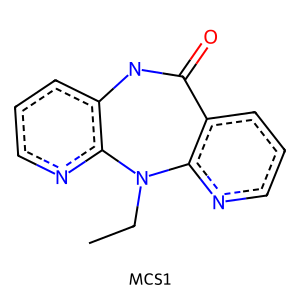

In [ ]:
#with default values
mcs1 = rdFMCS.FindMCS(mols)
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

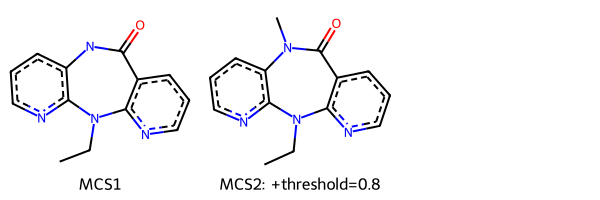

In [ ]:
#with setted threshold
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])


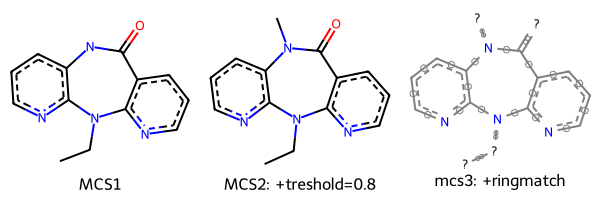

In [ ]:
#with matched ringbonds
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

Visualizing molecules from the largest cluster

Ten molecules from the largest cluster:


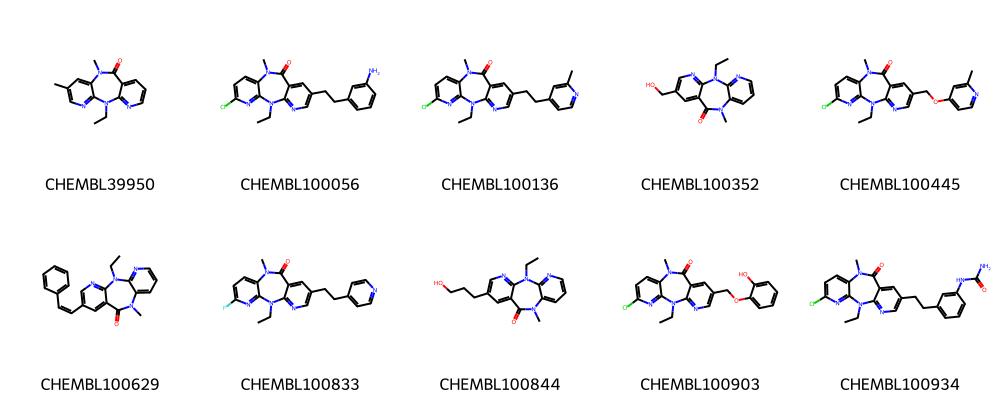

In [ ]:
print("Ten molecules from the largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

Now the same for the second largest cluster:

Computing the second largest cluster from the molecule set


In [ ]:
sdf = Chem.SDWriter("molecule_set_second_largest_cluster.sdf")

# writing mols into a file
for index in clusters[1]:
    mol, label = compounds[index]
    # addition of the metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)

sdf.flush()
sdf.close()

# reading mols from a file
supplier = Chem.ForwardSDMolSupplier("molecule_set_second_largest_cluster.sdf")
mols2 = [mol for mol in supplier if mol is not None]

Finding the Most Common Structure for the second largest cluster using rdFMCS from rdkit


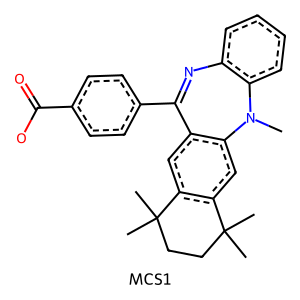

In [ ]:
#with default values
mcs1 = rdFMCS.FindMCS(mols2)
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

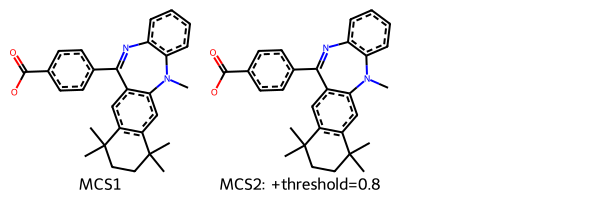

In [ ]:
#with setted threshold
mcs2 = rdFMCS.FindMCS(mols2, threshold=0.8)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

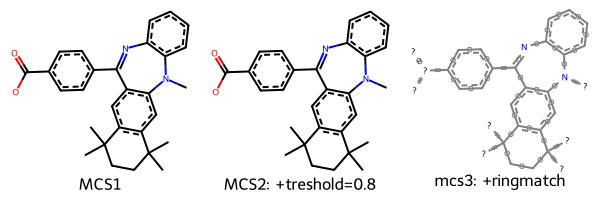

In [ ]:
#with matched ringbonds
mcs3 = rdFMCS.FindMCS(mols2, threshold=0.8, ringMatchesRingOnly=True)
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

Visualizing molecules from the second largest cluster


Ten molecules from the second largest cluster:


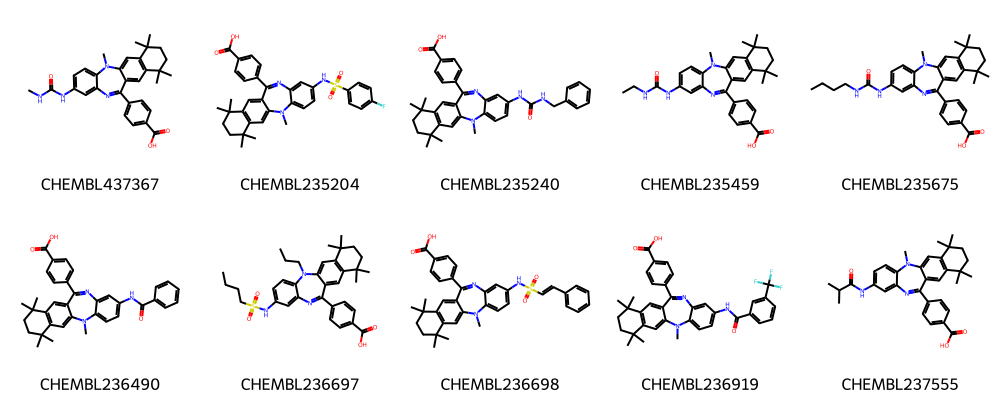

In [ ]:
print("Ten molecules from the second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][0:10]],
    legends=[compounds[i][1] for i in clusters[1][0:10]],
    molsPerRow=5,
)

### Intra-cluster Tanimoto similarities

Writing the function to compute Tanimoto similarity for all pairs of fingerprints in each cluster

In [ ]:
def intra_tanimoto(fps_clusters):
    intra_similarity = []
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

Recompute fingerprints for 10 first clusters

In [ ]:
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

Compute intra-cluster similarity

In [ ]:
intra_sim = intra_tanimoto(mol_fps_per_cluster)

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Violin plot with intra-cluster similarity


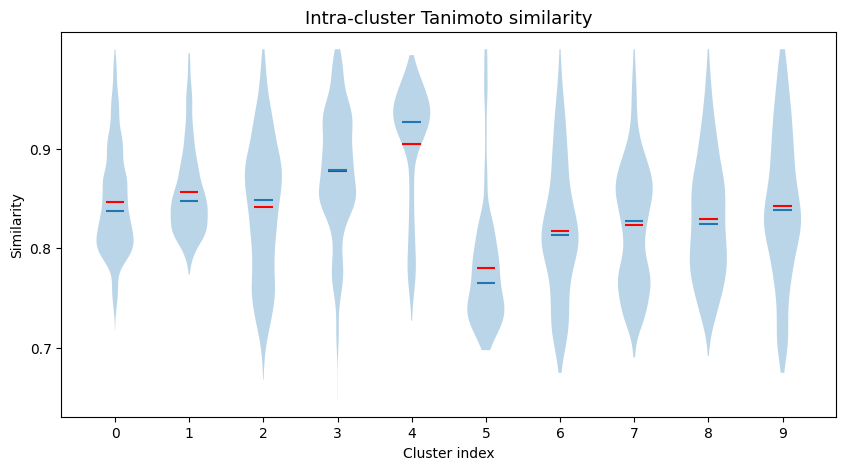

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

In [ ]:
compound_df.to_csv(r'compound_cluster.csv', index=False, sep=',')